*Disclaimer*: This notebook borrows from different sources including the IBMs tutorial on [parameterized quantum circuits](https://learn.qiskit.org/course/machine-learning/parameterized-quantum-circuits) and [training of parameterized quantum circuits](https://learn.qiskit.org/course/machine-learning/training-quantum-circuits).

# Parameterized Quantum Circuits

Parameterized quantum circuits (PQCs) are defined through gates that are defined by tunable parameters. PQCs can have different forms, ranging from very simple to highly complex with varying numbers of layers.

## Representing parameters in PQCs

The [`Parameter`](https://qiskit.org/documentation/stubs/qiskit.circuit.Parameter.html) class allows us to add a rotational gate without specifying the angles yet. The value of the parameter can be bound at a later step.

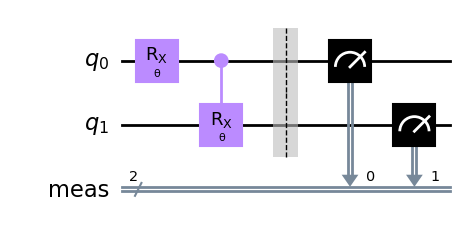

In [1]:
from qiskit.circuit import QuantumCircuit, Parameter

theta = Parameter("θ")

qc = QuantumCircuit(2)
qc.rx(theta, 0)
qc.crx(theta, 0, 1)
qc.measure_all()
qc.draw("mpl")

If we want the gates to have different parameters, we can use two parameters or we create a [`ParameterVector`](https://qiskit.org/documentation/stubs/qiskit.circuit.ParameterVector.html).

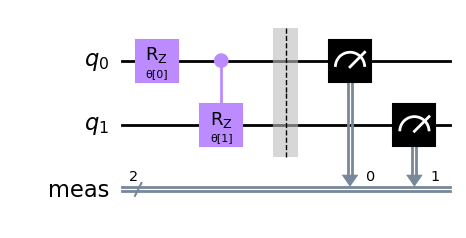

In [2]:
from qiskit.circuit import ParameterVector
theta_list = ParameterVector('θ', length=2)

qc = QuantumCircuit(2)
qc.rz(theta_list[0], 0)
qc.crz(theta_list[1], 0, 1)
qc.measure_all()
qc.draw("mpl")

### Entangling capability of Bell states

Let's use a parameterized CX gate to visualize the influence of angles using the just presented method of using `Parameter` by binding values in the range $[0, 2\pi]$ to it.

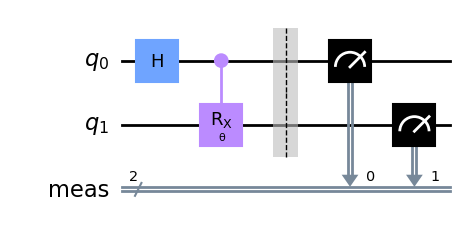

In [3]:
theta = Parameter("θ")

qc = QuantumCircuit(2)
qc.h(0)
qc.crx(theta, 0, 1)
qc.measure_all()
qc.draw("mpl")

In [4]:
import numpy as np

theta_range = np.linspace(0, 2 * np.pi, 128)

circuits = [qc.bind_parameters({theta: theta_val})
            for theta_val in theta_range]

In [5]:
from qiskit import BasicAer
from qiskit.compiler import transpile

backend = BasicAer.get_backend('qasm_simulator')
job = backend.run(transpile(circuits, backend))
counts = job.result().get_counts()

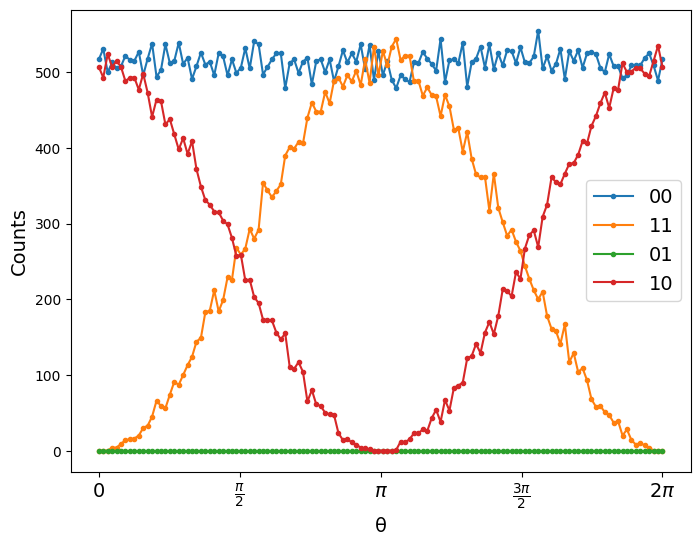

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.plot(theta_range, list(map(lambda c: c.get('00', 0), counts)), '.-', label='00')
ax.plot(theta_range, list(map(lambda c: c.get('11', 0), counts)), '.-', label='11')
ax.plot(theta_range, list(map(lambda c: c.get('10', 0), counts)), '.-', label='01')
ax.plot(theta_range, list(map(lambda c: c.get('01', 0), counts)), '.-', label='10')

ax.set_xticks([i * np.pi / 2 for i in range(5)])
ax.set_xticklabels(['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$'], fontsize=14)
ax.set_xlabel('θ', fontsize=14)
ax.set_ylabel('Counts', fontsize=14)
ax.legend(fontsize=14)

## Creating various types of PQCs

Qiskit offers several classes to directly create PQCs following the proposed ansätze given in various literature.

### Two-Local
Qiskit offers the [`TwoLocal`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.TwoLocal.html) circuit to build PQCs that consist of alternating one-qubit rotation layers followed by an entangling layer.

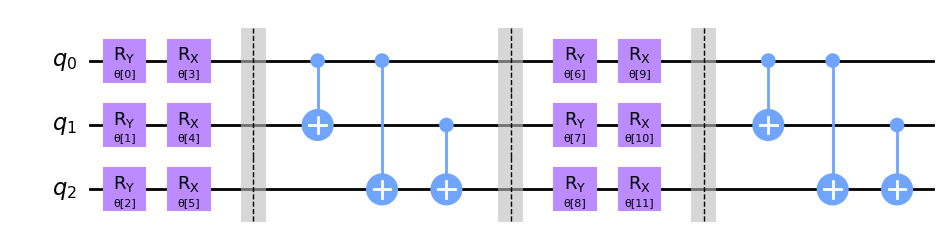

In [7]:
from qiskit.circuit.library import TwoLocal
qc_twolocal = TwoLocal(num_qubits=3, reps=2, rotation_blocks=['ry','rx'],
                entanglement_blocks='cx', skip_final_rotation_layer=True,
                insert_barriers=True)

qc_twolocal.decompose().draw("mpl")

With the `TwoLocal` circuit the different ansätze presented in our lecture such as "circuit 13" can easily be build.

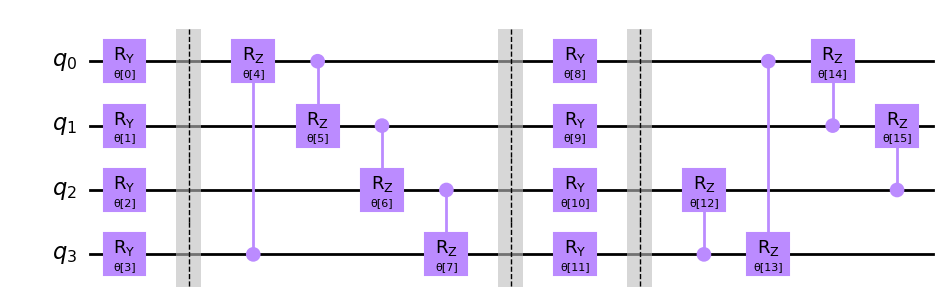

In [8]:
circuit_13 = TwoLocal(4, rotation_blocks='ry',
                 entanglement_blocks='crz', entanglement='sca',
                 reps=2, skip_final_rotation_layer=True,
                 insert_barriers=True)

circuit_13.decompose().draw("mpl")

If required, the [`NLocal`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.NLocal.html) circuit can create more generalized PQCs.

# PQCs for Machine Learning

To optimally benefit from advanced methods and frameworks well-known from machine learning, we are specifically interested in how to partially differentiate PQCs, i.e. how to determine the gradients.

## Gradients for QML

Qiskit provides different methods to compute gradients of expectation values.

To explore the different methods, we use the [`RealAmplitudes`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RealAmplitudes.html) circuit to get a parameterized state $|\psi_\theta\rangle = U_\theta|0\dots0\rangle$. The `RealAmplitudes` circuit is a heuristic trial wave function that is often used as Ansatz in quantum chemistry applications or classification for machine learning. In this example, it is our unitary $U_\theta$.

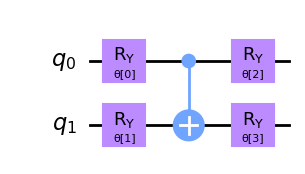

In [9]:
from qiskit.circuit.library import RealAmplitudes
ansatz = RealAmplitudes(num_qubits=2, reps=1,
                        entanglement='linear').decompose()
ansatz.draw("mpl")

The measurement operator we want to use here is $\mathcal{M} =Z \otimes Z$.

In [10]:
from qiskit.opflow import Z
measurement = Z ^ Z

Putting our parameterized quantum circuit and measurement together, we have $\langle \psi_\theta | \mathcal{M}| \psi_\theta \rangle$.

In [11]:
from qiskit.opflow import StateFn, PauliExpectation
expectation = StateFn(measurement, is_measurement=True) @ StateFn(ansatz)
pauli_basis = PauliExpectation().convert(expectation)

Next we do the simulation to get our expectation values.

In [12]:
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.opflow import PauliExpectation, CircuitSampler

quantum_instance = QuantumInstance(Aer.get_backend('qasm_simulator'),
                                   # we'll set a seed for reproducibility
                                   shots = 8192, seed_simulator = 2718,
                                   seed_transpiler = 2718)
sampler = CircuitSampler(quantum_instance)

def evaluate_expectation(theta):
    value_dict = dict(zip(ansatz.parameters, theta))
    result = sampler.convert(pauli_basis, params=value_dict).eval()
    return np.real(result)

We now fix a point `p` and an index `i` to ask for the derivative of the expectation value with respect to parameter $\theta_i$ at point `p`.

In [13]:
import numpy as np
point = np.random.random(ansatz.num_parameters)
INDEX = 2

### Finite Difference Gradients

Known from classical methods we can approximate gradients with a finite difference scheme, independent of the complexity of function to differentiate.

In [14]:
EPS = 0.2
# make identity vector with a 1 at index ``INDEX``, otherwise 0
e_i = np.identity(point.size)[:, INDEX]

plus = point + EPS * e_i
minus = point - EPS * e_i

finite_difference = (
    evaluate_expectation(plus) - evaluate_expectation(minus)) / (2 * EPS)
print(finite_difference)

-0.40039062500000056


Qiskit also provides a function for us we can use directly: [`Gradient`](https://qiskit.org/documentation/stubs/qiskit.aqua.operators.gradients.Gradient.html).

In [15]:
from qiskit.opflow import Gradient

shifter = Gradient('fin_diff', analytic=False, epsilon=EPS)
grad = shifter.convert(expectation, params=ansatz.parameters[INDEX])
print(grad)

value_dict = dict(zip(ansatz.parameters, point))
sampler.convert(grad, value_dict).eval().real

SummedOp([
  2.5 * ComposedOp([
    OperatorMeasurement(ZZ),
    CircuitStateFn(
         ┌──────────┐     ┌────────────────┐
    q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2] + 0.2) ├
         ├──────────┤┌─┴─┐└──┬──────────┬──┘
    q_1: ┤ Ry(θ[1]) ├┤ X ├───┤ Ry(θ[3]) ├───
         └──────────┘└───┘   └──────────┘   
    )
  ]),
  -2.5 * ComposedOp([
    OperatorMeasurement(ZZ),
    CircuitStateFn(
         ┌──────────┐     ┌────────────────┐
    q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2] - 0.2) ├
         ├──────────┤┌─┴─┐└──┬──────────┬──┘
    q_1: ┤ Ry(θ[1]) ├┤ X ├───┤ Ry(θ[3]) ├───
         └──────────┘└───┘   └──────────┘   
    )
  ])
])


-0.4144287109375

### Analytic Gradients with Parameter-Shift Rule

It was shown in literature that for simple circuits consisting only of Pauli rotation gates, the analytic gradient can be determined with parameter-shift rule:

$$\frac{\partial f}{\partial \theta_i} = \frac{f(\theta + \frac{\pi}{2} e_i) - f(\theta - \frac{\pi}{2} e_i)}{2}$$

Note that the parameter-shift rule is very similar to the finite difference method.

In [16]:
EPS = np.pi / 2
e_i = np.identity(point.size)[:, INDEX]

plus = point + EPS * e_i
minus = point - EPS * e_i

analytic_gradient = (
    evaluate_expectation(plus) - evaluate_expectation(minus)) / 2

print(analytic_gradient)

-0.40686035156250006


And using the `Gradient` class...

In [17]:
shifter = Gradient()  # parameter-shift rule is the default
grad = shifter.convert(expectation, params=ansatz.parameters[INDEX])
sampler.convert(grad, value_dict).eval().real

-0.41650390625

## Optimizing the expectation value using gradients

Let's first set an initial point for reproducibility.

In [18]:
# initial_point = np.random.random(ansatz.num_parameters)
initial_point = np.array([0.43253681, 0.09507794, 0.42805949, 0.34210341])

In [19]:
gradient = Gradient().convert(expectation)
gradient_in_pauli_basis = PauliExpectation().convert(gradient)
sampler = CircuitSampler(quantum_instance)

def evaluate_gradient(theta):
    value_dict = dict(zip(ansatz.parameters, theta))
    result = sampler.convert(gradient_in_pauli_basis,
                             params=value_dict).eval()
    return np.real(result)

In [20]:
class OptimizerLog:
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.loss = []
    def update(self, _nfevs, _theta, ftheta, *_):
        """Save intermediate results. Optimizers pass many values
        but we only store the third ."""
        self.loss.append(ftheta)
    def clear(self):
        self.loss.clear()

from qiskit.algorithms.optimizers import GradientDescent
gd_log = OptimizerLog()
gd = GradientDescent(maxiter=300,
                     learning_rate=0.01,
                     callback=gd_log.update)

Let's do the optimization now to check out our loss curve.

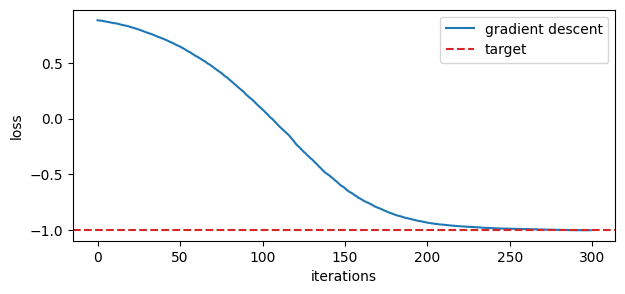

In [21]:
gd_log.clear()
result = gd.minimize(
    fun=evaluate_expectation,  # function to minimize
    x0=initial_point,          # initial point
    jac=evaluate_gradient      # function to evaluate gradient
)

import matplotlib.pyplot as plt
plt.figure(figsize=(7, 3))
plt.plot(gd_log.loss, label='gradient descent')
plt.axhline(-1, ls='--', c='C3', label='target')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend()
plt.show()

In [22]:
import qiskit.tools.jupyter
%qiskit_version_table